**Project Scope and Functional Objectives**
Project Scope

The project focuses on analyzing household energy consumption data to understand usage patterns and predict future electricity demand. It involves data preprocessing, time-series analysis, feature engineering, and baseline machine learning modeling to support energy efficiency and smart usage decisions.

Functional Objectives
1.  Preprocess and clean energy consumption data
2.  Analyze hourly, daily, and monthly energy usage trends
3.  Extract time-based and lag features for forecasting
4.   Develop a baseline Linear Regression model
5. Evaluate predictions using MAE and RMSE metrics

**Import Required Libraries**

In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


**Load Dataset**

In [4]:
# Load dataset with correct separator
df = pd.read_csv("/content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption.txt", sep=';')

# View first rows
df.head()

/tmp/ipython-input-463529903.py:2: DtypeWarning: Columns (2,3,4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/individual+household+electric+power+consumption/household_power_consumption.txt", sep=';')


,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


**Dataset Overview**

In [5]:
# Dataset shape
print("Dataset Shape:", df.shape)

# Column names
print("\nColumns:\n", df.columns)

# Data types
print("\nData Types:")
print(df.dtypes)

# Missing values
print("\nMissing Values:")
print(df.isnull().sum())


Dataset Shape: (2075259, 9)

Columns:
 Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')

Data Types:
Date                      object
Time                      object
Global_active_power       object
Global_reactive_power     object
Voltage                   object
Global_intensity          object
Sub_metering_1            object
Sub_metering_2            object
Sub_metering_3           float64
dtype: object

Missing Values:
Date                         0
Time                         0
Global_active_power          0
Global_reactive_power        0
Voltage                      0
Global_intensity             0
Sub_metering_1               0
Sub_metering_2               0
Sub_metering_3           25979
dtype: int64


**Replace Missing Value Symbol and Convert Numerical Columns**

In [6]:
# Replace '?' with NaN
df.replace('?', np.nan, inplace=True)
numeric_cols = [
    'Global_active_power', 'Global_reactive_power',
    'Voltage', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3'
]

df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric)


**Create Timestamp Column**

In [7]:
df['timestamp'] = pd.to_datetime(
    df['Date'] + ' ' + df['Time'],
    dayfirst=True,
    errors='coerce'
)

df = df.dropna(subset=['timestamp'])
df.set_index('timestamp', inplace=True)
df.drop(['Date', 'Time'], axis=1, inplace=True)


**Handle Missing Values**

In [8]:
# Forward fill missing values
df.fillna(method='ffill', inplace=True)

# Final missing check
print("\nMissing Values After Cleaning:")
print(df.isnull().sum())


Missing Values After Cleaning:
Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64


/tmp/ipython-input-75524706.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [9]:
df.drop_duplicates(inplace=True)

**Outlier Handling (IQR Method)**

In [10]:
Q1 = df['Global_active_power'].quantile(0.25)
Q3 = df['Global_active_power'].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

df['Global_active_power'] = np.clip(
    df['Global_active_power'], lower, upper
)

**Resampling Hourly and Daily Data**

In [11]:
hourly_df = df.resample('h').mean()
daily_df = df.resample('d').mean()
print(hourly_df.index.min())
print(hourly_df.index.max())


2006-12-16 17:00:00
2010-11-26 21:00:00


**Normalize Power Consumption**

In [12]:
scaler = MinMaxScaler()

hourly_df['power_scaled'] = scaler.fit_transform(
    hourly_df[['Global_active_power']]
)

daily_df['power_scaled'] = scaler.fit_transform(
    daily_df[['Global_active_power']]
)


**Train–Validation–Test Split**

In [13]:
def split_data(data, train=0.7, val=0.15):
    train_end = int(len(data) * train)
    val_end = train_end + int(len(data) * val)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

train, val, test = split_data(hourly_df)

print("Train size:", train.shape)
print("Validation size:", val.shape)
print("Test size:", test.shape)


Train size: (24212, 8)
Validation size: (5188, 8)
Test size: (5189, 8)


**Exploratory Data Analysis (EDA)**
**Hourly Trend**

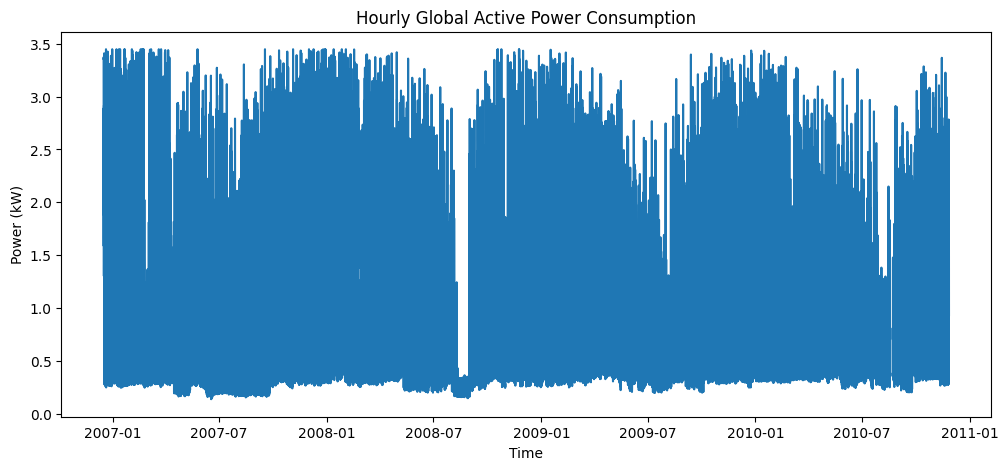

In [14]:
plt.figure(figsize=(12,5))
plt.plot(hourly_df.index, hourly_df['Global_active_power'])
plt.title("Hourly Global Active Power Consumption")
plt.xlabel("Time")
plt.ylabel("Power (kW)")
plt.show()

**Exploratory Data Analysis (EDA) Daily Trend**

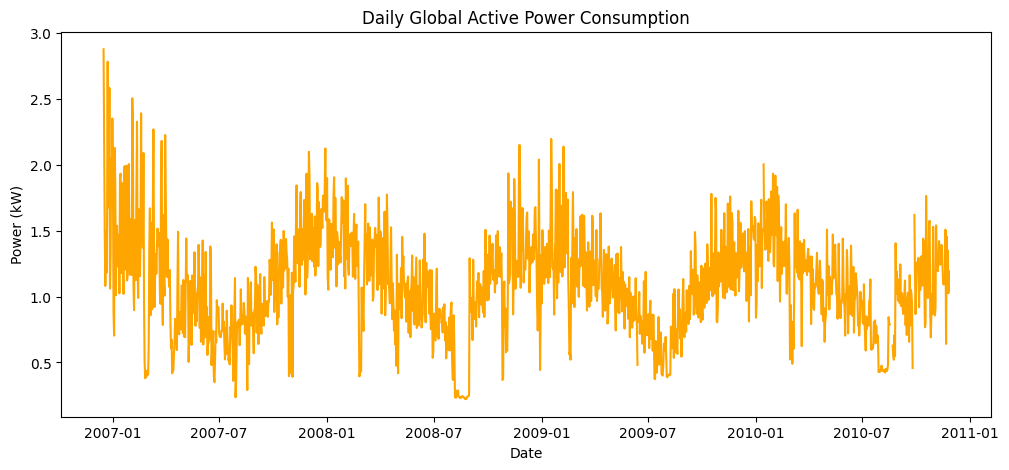

In [15]:
plt.figure(figsize=(12,5))
plt.plot(daily_df.index, daily_df['Global_active_power'], color='orange')
plt.title("Daily Global Active Power Consumption")
plt.xlabel("Date")
plt.ylabel("Power (kW)")
plt.show()


**Exploratory Data Analysis (EDA) Distribution Plot**

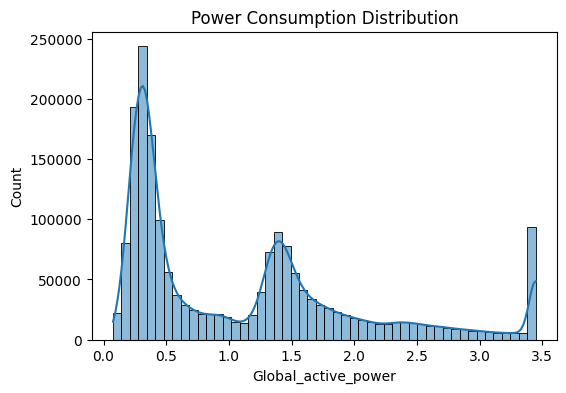

In [16]:
plt.figure(figsize=(6,4))
sns.histplot(df['Global_active_power'], bins=50, kde=True)
plt.title("Power Consumption Distribution")
plt.show()

In [17]:
# Save cleaned and resampled data for next milestone
hourly_df.reset_index().to_csv(
    "/content/drive/MyDrive/cleaned_energy_data_milestone1.csv",
    index=False
)

print("Cleaned dataset saved for Milestone 2")


Cleaned dataset saved for Milestone 2
